# Heterogeneous Array Mosaic Simulations and Imaging

CASR-524 : ALMA. CASR-301 : ngVLA : ALMA (CASR-514) and NGVLA (CASR-301) need the ability to simulate and image data from an array containing different dish sizes, arbitrarily specifiable names for the telescope and antenna types, support for cross baseline visibilities, and realistic noise predictions for each baseline type. 

__Topics Covered below__

    - Construct an MS with multiple sets of antenna sizes and cross-baselines
    - Predict visibilities with correct PB application during simulation
    - Image the data with correct PB application during imaging
    - Introduce noise per baseline type and track it through to imaging
    
__Use Cases__

    - ALMA single pointing + mosaic  cube
    - ngVLA single pointing + mosaic  cube
   
__Tests__
   
(1) Test het-array model prediction and imaging using the Mosaic gridder.
   
   For a 1 Jy source, 
   - For baselines within each antenna type, image and PB should match.
   - For cross baselines, PB(cross) = sqrt( PB(type1) * PB(type2) )  and similarly for the image flux. Image and PB should match.
   - For all baselines together, image and PB should match
   
(2) Test adding noise and measuring noise in cleaned images
   
   - Add noise to all visibilities. 
       - sm.setnoise(mode='tsys-atm') will do dish sizes automatically (but not accurate for cross-baselines)
       - custom function to compute noise based only on dish diameter
   - Image different subsets and measure noise level.
   - Calculated expected noise levels for cross baselines and joint imaging, using appropriate weighted and quadrature averages, and measure what we get. They should match. 

(3) Test setting arbitrary antenna and telescope names (and PB models) 
   - Known and Unknown observatory name
   - Arbitrary antenna names
   - For unknown PB models,
       - Default : Calculate an Airy Dish model from the dish diameter information in the ANTENNA subtable
       - Custom : Use the vptable to specify custom Voltage Patterns

   
   
***

# Metrics to validate the simulation script

Compare theoretically calculated values for weights, sigma, visibility noise, image intensity, primary beam, and image rms with those measured from the simulated dataset and the above imaging runs. Perform imaging separately for A, B, and cross baselines as well as all together and match theoretical versus measured metrics. 

#### Baseline Types
Four baseline groups were used in these tests
 - All A-A baselines
 - All B-B baselines
 - Cross baselines A-B
 - All baselines together

#### Weights, Sigma
 
The weights and sigma are related to the effective dish diameter. 
 - The (normalized) effective area for each baseline type is $A_{eff} = \frac{ D_1 D_2 }{D_{max}^2} $ where 1 and 2 map to the two antennas in each baseline pair.
 - $\sigma \propto \frac{1}{A_{eff}}$ 
 - $W =  \frac{1}{\sigma^2}$  or  $W \propto A_{eff}^2$

#### Visibility Noise
Gaussian random additive noise was simulated with a zero mean and a standard deviation given by $\sigma = \frac{1}{A_{eff}} \cdot \frac{1}{1000}$ to generate a noise level that is clearly seen in visibility plots but not enough to drown out the visibility amplitude per baseline type. 

To validate the simulated noise levels in the visibilities, we can measure the standard deviation of the visibilities per baseline type, and check that their ratios are consistent with the differences in dish area.  (Source contribution is a constant).
 - For an independent calculation of Gaussian Random noise given by $\sigma$ above for each baseline type, Result : They are very close, not exact (need more data points, or error in usage of np.random...)
 - For sm.setnoise(mode='tsys-atm');sm.corrupt(), the cross-baseline noise level does not match the expectation based on dish area. (AM has identified lines of code where cross-baseline calcs are possibly incorrect.)
 

#### Image Intensity (and Primary Beam)
For a 1 Jy source, the measured visibility amplitude should match the PB gain value. 

When each baseline type is imaged separately, the intensity of a 1 Jy source is given by the effective PB gain level for that baseline type. The relative weighting between baseline types is irrelevant. 
 - For baselines of the same antenna type, $I_{A} = P_{A}, I_{B} = P_{B}$
 - For cross baselines, $I_{cross} = \sqrt{P_{A}\cdot P_{B}}$ 

For an imaging run that combines all baselines, the relative weights between baselines must be appropriately considered. The intensity will be a weighted average of the intensities, where the weight per baseline type is given by the number of data points x weight for that baseline type. 

\begin{equation}
    I_{all} = \frac{ \left(I_{A} \cdot n_{A} \cdot W_{A}\right) + \left(I_{B} \cdot n_{B} \cdot W_{B}\right) + \left(I_{cross} \cdot n_{cross} \cdot W_{cross}\right)} {W_{sum}} 
    \end{equation}

where the sum of weights is given as : 
\begin{equation}
W_{sum} = (n_{B} \cdot W_{B})+(n_{A} \cdot W_{A})+(n_{cross} \cdot W_{cross}) 
\end{equation}

#### Image RMS

When each baseline type is imaged separately,The expected image rms is given by 
\begin{equation}
\sigma_{im} = \frac{\sigma_{vis}}{\sqrt{N}}
\end{equation}
where $\sigma_{vis}$ is the standard deviation of the visibility values (per baseline type) and $N$ is the number of data points per baseline type. 


For an imaging run that combines all baselines, the image rms will be the weighted quadrature sum of the image rms from each of the baseline types separately. 


The rms, added in quadrature, is
\begin{equation}
\sigma_{im,all} = \sqrt{{ \left(\frac{\sigma_{im,A}\cdot W_{A}\cdot n_{A}}{ W_{sum}} \right)^2 + \left( \frac{\sigma_{im,B}\cdot W_{B}\cdot n_{B}}{W_{sum}} \right)^2 + \left(\frac{\sigma_{im,cross}\cdot W_{cross}\cdot n_{cross}}{W_{sum}}\right)^2 }}
\end{equation}

***
### Information about plots in this notebook. 
The plots shown in this notebook have been generated by first converting the MS into an XArray DataSet and then using Python XArray plotting capabilities. The XPlot function uses cngi-prototype code. The display_image function uses Astropy. For running in a conventional casa6 installation without any other packages, please skip these XPlot and image display calls and use the "plotms" and "viewer/imview" instead. 

The XPlot function takes a 'forceconvert=True/False' parameter to convert the MS to Zarr/XArray before making a plot. Please set to True/False as appropriate. Note that the conversion will produce some diagnostic output. To suppress this after the first run, re-run the XPlot command cell with with forceconvert=False (default). 
***

# ALMA Simulation

In [7]:
%run -i Sim_Heterogeneous_Array_Script.py
%run -i Display_Experiments_Script.py
#%matplotlib widget
#%matplotlib inline

## Make an empty Measurement Set

In [2]:
makeMSFrame(msn='sim_data', tel='ALMA')

Making an MS named : sim_data_ALMA.ms


Completed ddi 0  process time 0.47 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.76 s...                                     
                                                  
overwrite_encoded_chunks True


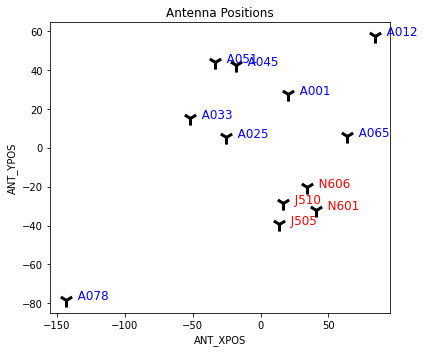

In [8]:
XPlot(vis='sim_data_ALMA.ms', ptype='plotants',forceconvert=True)

overwrite_encoded_chunks True


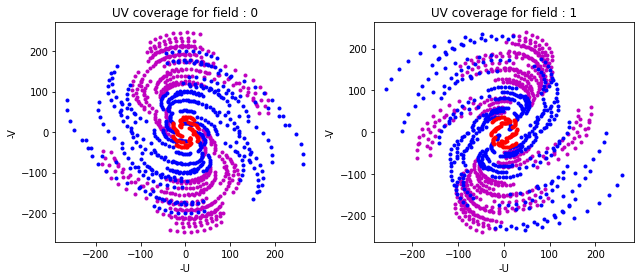

In [9]:
XPlot(vis='sim_data_ALMA.ms', ptype='uvcov')

In [5]:
listobs_jupyter(vis='sim_data_ALMA.ms')

           MeasurementSet Name:  /home/vega/rurvashi/TestCASA/NoteBooks/Simulation-in-CASA/Heterogeneous_Array_Simulation_and_Imaging/sim_data_ALMA.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: ALMA(12 antennas)
Data records: 1188       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2020/18:39:56.4   to   04-Oct-2020/04:39:56.4 (UTC)

Fields: 2
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake1               19:59:28.500000 -40.44.01.50000 J2000   0            594
  1         fake2               19:59:28.500000 -40.44.51.50000 J2000   1            594
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      Band3      5   TOPO   90000.000   2000000.000  10000000.0  94000.0000   XX  YY
Antennas: 12 'name'='station' 
   ID=   0-4: 'A001'='P', 'A012'='P'

## Make a True Sky Model 

In [6]:
## Make the component list
makeCompList(clname_true='sim_onepoint_alma.cl')

## Make an empty CASA image
makeEmptyImage(imname_true='sim_onepoint_true_alma.im')
## Evaluate the component list onto the CASA image
evalCompList(clname='sim_onepoint_alma.cl', imname='sim_onepoint_true_alma.im')

Peak Intensity (chan0) : 1.0000000


(1.0, None)

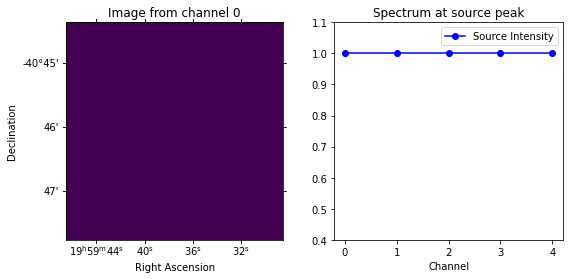

In [7]:
## Display
displayImage(imname='sim_onepoint_true_alma.im')

## Simulate visibilities from the sky model

Simulate visibilities for the true sky model, using the Mosaic gridder.

In [8]:
%run -i Sim_Heterogeneous_Array_Script.py
%run -i Display_Experiments_Script.py

In [9]:
predictImager(msname='sim_data_ALMA.ms',imname_true='sim_onepoint_true_alma.im', tel='ALMA')
copyModelToData(msname='sim_data_ALMA.ms')

In [10]:
os.system("rm -rf sim_data_ALMA_no_noise.ms")
os.system("cp -r sim_data_ALMA.ms sim_data_ALMA_no_noise.ms")

0

Completed ddi 0  process time 0.59 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.80 s...                                     
                                                  
overwrite_encoded_chunks True


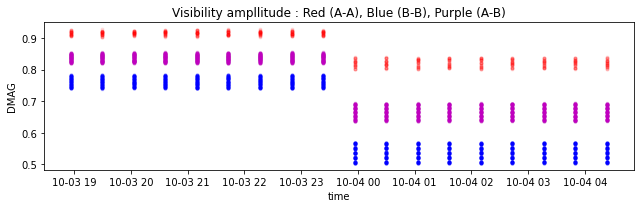

In [10]:
XPlot(vis='sim_data_ALMA_no_noise.ms', ptype='amp-time',forceconvert=True)

The three baseline types are visible in this plot (colors) with the left and right halves corresponding to the two overlapping pointings.  There are 5 channels in this dataset, and the vertical variation is due to the PB frequency dependence. 

overwrite_encoded_chunks True


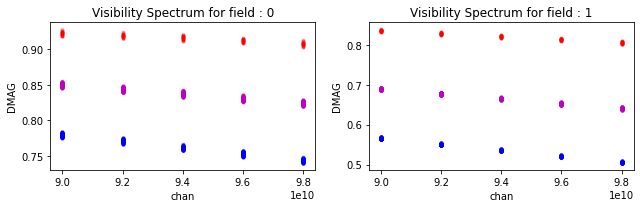

In [11]:
XPlot(vis='sim_data_ALMA_no_noise.ms', ptype='amp-freq')

In this plot, one channel of data is plotted as a function of time. The left and right halves of the plot correspond to the two different pointings in this simulated dataset. The three distinct visibility amplitudes correspond to the 7m-7m baselines at the top, the 12m-7m baselines in the middle and the 12m-12m baselines at the bottom, mapping directly to the gain level of the effecting baseline primary beams. 

## Add visibility noise

In [12]:
addDishNoise(msname='sim_data_ALMA.ms')

Completed ddi 0  process time 0.52 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.76 s...                                     
                                                  
overwrite_encoded_chunks True


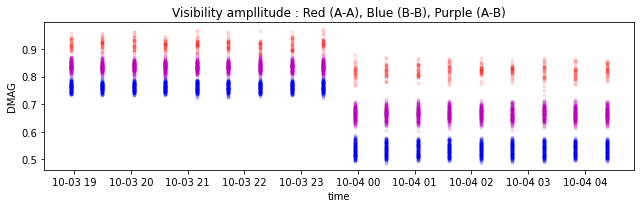

In [12]:
XPlot(vis='sim_data_ALMA.ms', ptype='amp-time',forceconvert=True);

Noise has been added. Visibilities from the smaller dishes, with the largest primary beams and higher visibility amplitudes, show more scatter.    Numerical/statistical checks of noise levels are shown below after the imaging results. 

overwrite_encoded_chunks True


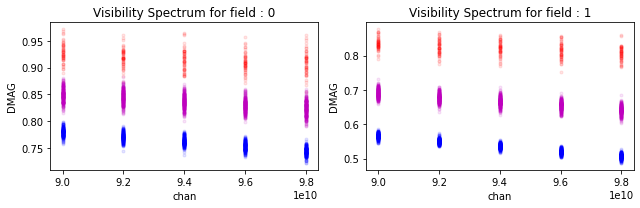

In [13]:
XPlot(vis='sim_data_ALMA.ms', ptype='amp-freq')

In [ ]:
### Make another MS with   addNoiseSim() to test out sm.corrupt with 'tsys-atm'
#addNoiseSim(msname='sim_data_ALMA.ms')

## Run the imaging tests for One Pointing

In [13]:
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0',antsel='A')
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0',antsel='B')
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0',antsel='cross')
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0',antsel='all')


### 12m-12m
Image only the 12m-12m baselines, with one pointing. The source is located at about the 0.78 gain level of the PB. For this 1 Jy source, the image and PB values should match.

Peak Intensity (chan0) : 0.7833865
PB at location of Intensity peak (chan0) : 0.7842705
Residual RMS : 0.0004705


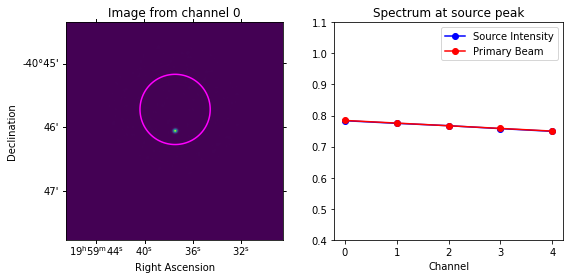

In [14]:
peak_12m,rms_12m = display_image(imprefix='try_ALMA_A_single')

### 7m-7m

Image only the 7m-7m baselines, with one pointing. The PB is bigger than with the 12m and the source is located at about the 0.92 gain level of the PB. For this 1 Jy source, the image and PB values should match. 

Peak Intensity (chan0) : 0.9395729
PB at location of Intensity peak (chan0) : 0.9348479
Residual RMS : 0.0029911


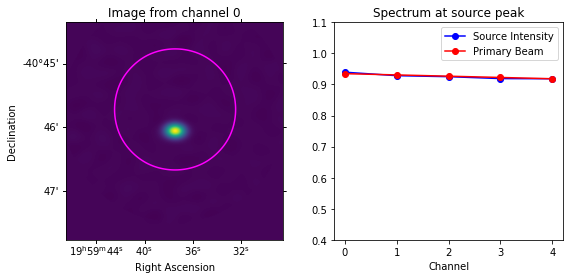

In [15]:
peak_7m,rms_7m = display_image(imprefix='try_ALMA_B_single')

### 12m-7m 


Image the cross baselines (12m-7m). Also, for this 1 Jy source, the Sky and PB values match. 

Peak Intensity (chan0) : 0.8538513
PB at location of Intensity peak (chan0) : 0.8558278
Residual RMS : 0.0006439


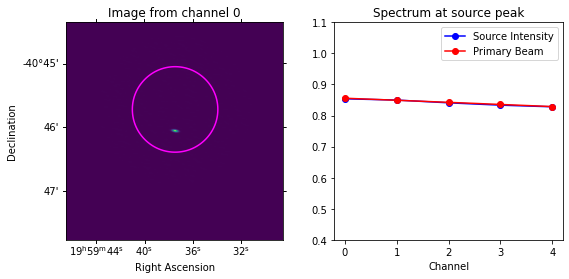

In [16]:
peak_cross,rms_cross = display_image(imprefix='try_ALMA_cross_single')

### All baselines together
Image all baselines. 

Peak Intensity (chan0) : 0.8064911
PB at location of Intensity peak (chan0) : 0.8073654
Residual RMS : 0.0003832


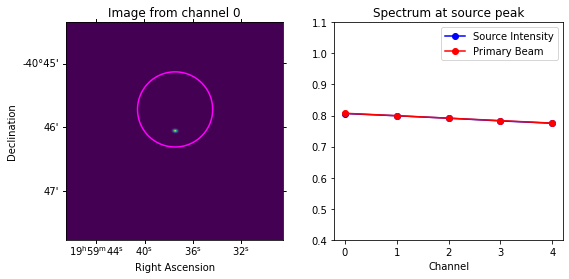

In [17]:
peak_all, rms_all = display_image(imprefix='try_ALMA_all_single')

### Verify the measured intensity, PB and noise levels.

In [18]:
%run -i Sim_Heterogeneous_Array_Script.py

In [19]:
antsels = getBaselineTypes()
meas_peaks = {'A':peak_12m, 'B':peak_7m, 'cross':peak_cross, 'all':peak_all}
meas_rms = {'A':rms_12m, 'B':rms_7m, 'cross':rms_cross, 'all':rms_all}
checkVals(vis='sim_data_ALMA.ms',field='0',spw='0:0',antsels=antsels, \
          meas_peaks=meas_peaks, meas_rms=meas_rms)
  

,Baseline Types,Vis Mean (V=I=P),Vis Std (sim),Vis Std (norm sim),Vis Std (calc),Number of Data Pts,Weight (calc),Weight (sim),Int Jy/bm (calc),Int Jy/bm (meas),RMS mJy (calc),RMS mJy (meas)
0,12m-12m,0.7790,0.0098,1.0000,1.0000,504.0000,1.0000,1.0000,0.7790,0.7834,0.4344,0.4705
1,7m-7m,0.9276,0.0273,2.7996,2.9388,108.0000,0.1158,0.1158,0.9276,0.9396,2.6273,2.9911
2,12m-7m,0.8488,0.0177,1.8145,1.7143,576.0000,0.3403,0.3403,0.8501,0.8539,0.7374,0.6439
3,All,-NA-,-NA-,-NA-,-NA-,-NA,-NA-,-NA-,0.8008,0.8065,0.3711,0.3832


Calculated PB size for type A (dia=12.00) : 0.95493 arcmin
Calculated PB size for type B (dia=7.00) : 1.63703 arcmin


In the above table,
 - Vis Mean : Mean of the visibility values. Representative of the source intensity (1 point source at phase center)
 - Vis StdDev : StdDev of the visibility values. Measurement of noise level.
 - Number of Pts : Number of data points (nbaselines x nchan x npol x ntimesteps).  In the above table, nchan=1
 - Mean Weight : Mean of the weight_spectrum column in the MS. 
 - Calc Int : Expected intensity. Same as the Vis Mean, for separate baseline types. Calculated as weighted average for the all-baseline case. 
 - Meas Int : Peak source intensity measured from the imaging results
 - Calc RMS : Expected image RMS. Calculated as described above.
 - Mean RMS : Measured image RMS from the residual image, within the PB mask area. 
 
 
The above single pointing tests are sufficient to verify that the simulation code is indeed working (this is one field from a two pointing mosaic dataset) as is the ability to image data from a heterogenous array. The match between intensity and primary beam for this 1 Jy source indicates accurate flux recovery, and weights, noise and image rms levels are consistent with theoretical expectations. 


## Run the Imaging tests for a Mosaic
The tests below cover joint mosaic imaging. 

In [20]:
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0,1',antsel='A')
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0,1',antsel='B')
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0,1',antsel='cross')
imageAnts(vis='sim_data_ALMA.ms',imname='try_ALMA', field='0,1',antsel='all')


### 12m-12m
Image only the 12m-12m baselines for a joint mosaic. For this 1 Jy source, the image and the PB values match. 

Peak Intensity (chan0) : 0.9503353
PB at location of Intensity peak (chan0) : 0.9512165
Residual RMS : 0.0004451


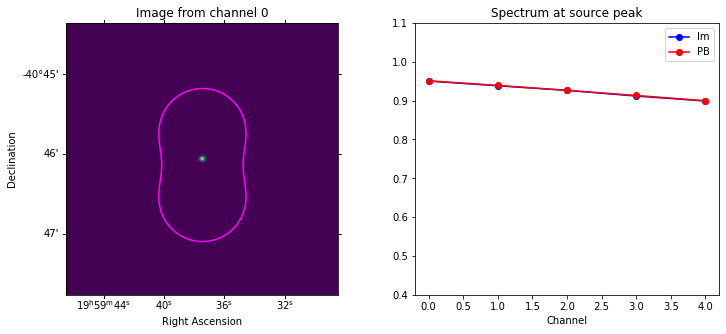

In [21]:
mospeak_12m,mosrms_12m = display_image(imprefix='try_ALMA_A_mosaic')

### 7m-7m
Image only the 7m-7m baselines for a joint mosaic. The joint PB is larger than the 12m PB. For this 1 Jy source, the Sky and PB match. 

Peak Intensity (chan0) : 0.9982999
PB at location of Intensity peak (chan0) : 0.9959393
Residual RMS : 0.0022583


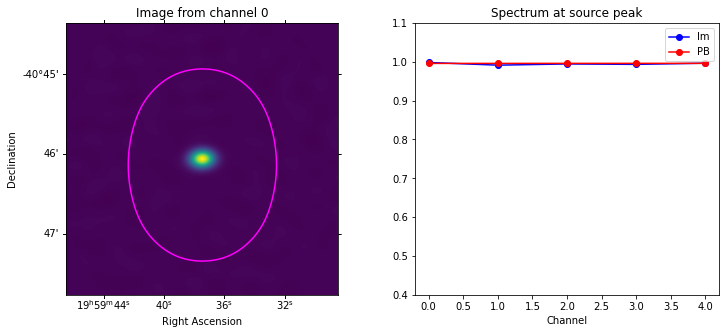

In [22]:
mospeak_7m,mosrms_7m = display_image(imprefix='try_ALMA_B_mosaic')

### 12m-7m 

Image the cross baselines and check that the values of Sky, PB and RMS match the predictions. 

Peak Intensity (chan0) : 0.9973467
PB at location of Intensity peak (chan0) : 0.9984403
Residual RMS : 0.0006251


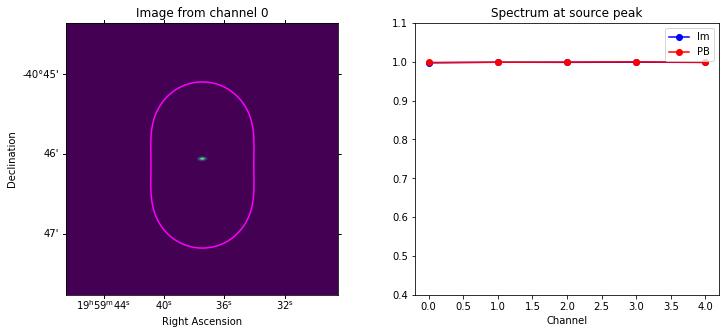

In [23]:
mospeak_cross,mosrms_cross = display_image(imprefix='try_ALMA_cross_mosaic')

### All baselines together

Image all baselines together with a mosaic. 

Peak Intensity (chan0) : 0.9769531
PB at location of Intensity peak (chan0) : 0.9776583
Residual RMS : 0.0003715


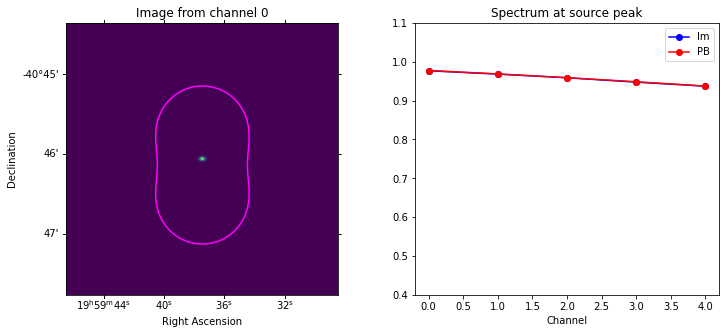

In [24]:
mospeak_all,mosrms_all = display_image(imprefix='try_ALMA_all_mosaic')

Some qualitative observations : 
- The intensity and PB values match for all cases.
- The shapes of the joint mosaic PBs for all 4 imaging cases are consistent with expectations from relative beam size and the number of data points per type. 

Note : The theoretical calculation from the single pointing case was not performed for the joint mosaic case. To do so, we would have to image/calculate the numbers for the second pointing separately, and then perform the appropriate PB-weighted means and quadrature sums. 


# NGVLA Simulation

In [28]:
%run -i Sim_Heterogeneous_Array_Script.py
%run -i Display_Experiments_Script.py

## Make an empty Measurement Set 

In [26]:
makeMSFrame(msn='sim_data', tel='NGVLA')

Making an MS named : sim_data_NGVLA.ms


Completed ddi 0  process time 0.45 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.76 s...                                     
                                                  
overwrite_encoded_chunks True


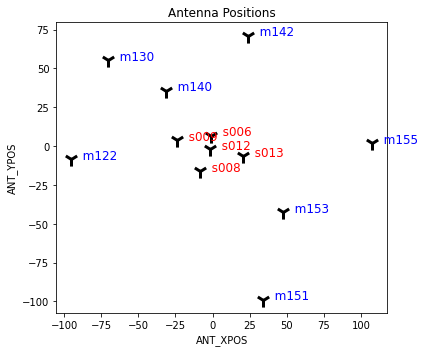

In [15]:
XPlot(vis='sim_data_NGVLA.ms', ptype='plotants',forceconvert=True,tel_name='ngVLA')

overwrite_encoded_chunks True


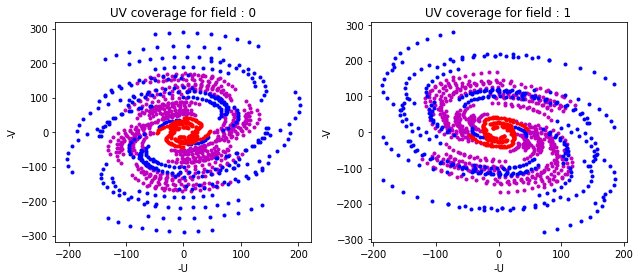

In [16]:
XPlot(vis='sim_data_NGVLA.ms', ptype='uvcov',tel_name='ngVLA')


In [31]:
listobs_jupyter(vis='sim_data_NGVLA.ms')

           MeasurementSet Name:  /home/vega/rurvashi/TestCASA/NoteBooks/Simulation-in-CASA/Heterogeneous_Array_Simulation_and_Imaging/sim_data_NGVLA.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: NGVLA1(12 antennas)
Data records: 1188       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2020/21:18:48.0   to   04-Oct-2020/07:18:48.0 (UTC)

Fields: 2
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake1               19:59:28.500000 +40.43.41.50000 J2000   0            594
  1         fake2               19:59:28.500000 +40.45.11.50000 J2000   1            594
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      Band5      5   TOPO   40000.000   2000000.000  10000000.0  44000.0000   XX  YY
Antennas: 12 'name'='station' 
   ID=   0-4: 'm140'='P', 'm142'=

## Make a True Sky Model 

In [32]:
## Make the component list
makeCompList(clname_true='sim_onepoint_ngvla.cl',tel='NGVLA')

## Make an empty CASA image
makeEmptyImage(imname_true='sim_onepoint_true_ngvla.im',tel='NGVLA')
## Evaluate the component list onto the CASA image
evalCompList(clname='sim_onepoint_ngvla.cl', imname='sim_onepoint_true_ngvla.im')

Peak Intensity (chan0) : 1.0000000


(1.0, None)

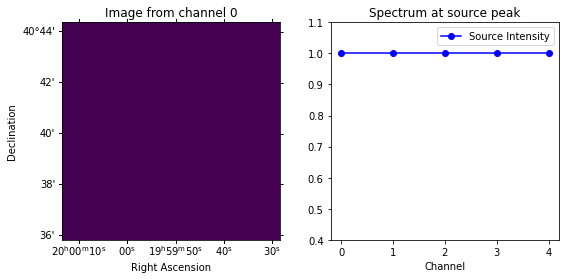

In [33]:
## Display
displayImage(imname='sim_onepoint_true_ngvla.im')

## Simulate visibilities from the sky model

Simulate visibilities for the true sky model, using the Mosaic gridder.

In [34]:
%run -i Sim_Heterogeneous_Array_Script.py
%run -i Display_Experiments_Script.py

In [35]:
predictImager(msname='sim_data_NGVLA.ms',imname_true='sim_onepoint_true_ngvla.im', tel='NGVLA')
copyModelToData(msname='sim_data_NGVLA.ms')

In [36]:
os.system("rm -rf sim_data_NGVLA_no_noise.ms")
os.system("cp -r sim_data_NGVLA.ms sim_data_NGVLA_no_noise.ms")
#msToZarr('sim_data_NGVLA_no_noise.ms')

0

Completed ddi 0  process time 0.54 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.82 s...                                     
                                                  
overwrite_encoded_chunks True


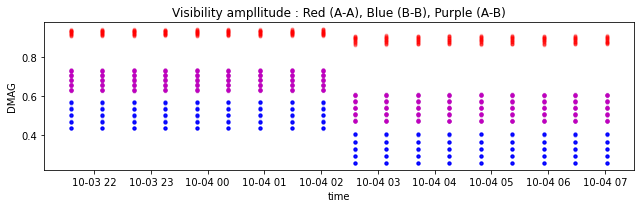

In [17]:
XPlot(vis='sim_data_NGVLA_no_noise.ms', ptype='amp-time',forceconvert=True,tel_name='ngVLA')

overwrite_encoded_chunks True


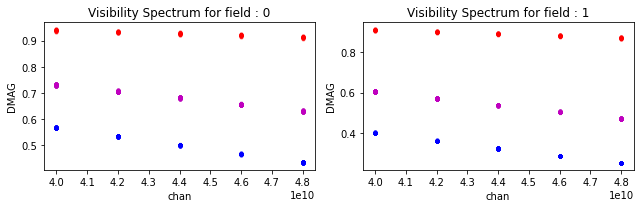

In [18]:
XPlot(vis='sim_data_NGVLA_no_noise.ms', ptype='amp-freq',tel_name='ngVLA')

In this plot, one channel of data is plotted as a function of time. The left and right halves of the plot correspond to the two different pointings in this simulated dataset. The three distinct visibility amplitudes correspond to the 6m-6m baselines at the top, the 18m-6m baselines in the middle and the 18m-18m baselines at the bottom, mapping directly to the gain level of the effecting baseline primary beams. 

## Add visibility noise

In [37]:
addDishNoise(msname='sim_data_NGVLA.ms')

Completed ddi 0  process time 0.60 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.81 s...                                     
                                                  
overwrite_encoded_chunks True


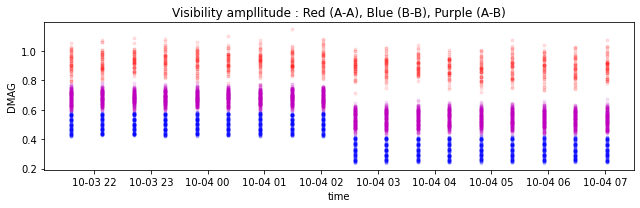

In [19]:
XPlot(vis='sim_data_NGVLA.ms', ptype='amp-time',forceconvert=True,tel_name='ngVLA')

overwrite_encoded_chunks True


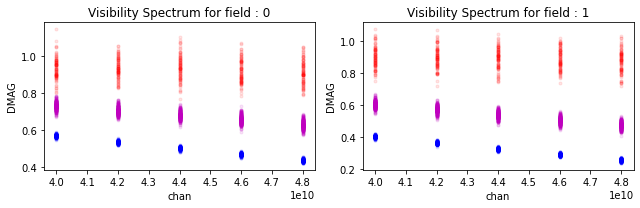

In [20]:
#%matplotlib widget 
XPlot(vis='sim_data_NGVLA.ms', ptype='amp-freq',tel_name='ngVLA')

In [ ]:
### Make another MS with   addNoiseSim() to test out sm.corrupt with 'tsys-atm'
#addNoiseSim(msname='sim_data_ALMA.ms')
####  This currently has errors in how noise is added for cross baselines. 

## Run the imaging tests for One Pointing

In [38]:
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0',antsel='A',tel='NGVLA')
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0',antsel='B',tel='NGVLA')
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0',antsel='cross',tel='NGVLA')
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0',antsel='all',tel='NGVLA')


### 18m-18m
Image only the 18m-18m baselines, with one pointing. The source is located at about the 0.5 gain level of the PB. For this 1 Jy source, the image and PB values should match.

Peak Intensity (chan0) : 0.5718917
PB at location of Intensity peak (chan0) : 0.5711437
Residual RMS : 0.0004892


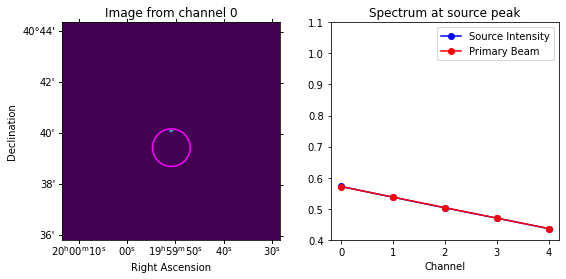

In [39]:
peak_18m,rms_18m = display_image(imprefix='try_NGVLA_A_single')

### 6m-6m

Image only the 6m-6m baselines, with one pointing. The PB is bigger than with the 12m and the source is located at about the 0.93 gain level of the PB. For this 1 Jy source, the image and PB values should match. 

Peak Intensity (chan0) : 0.9382882
PB at location of Intensity peak (chan0) : 0.9466081
Residual RMS : 0.0063216


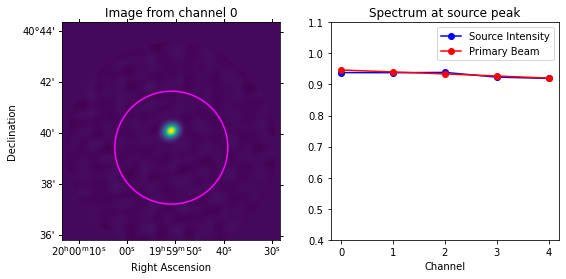

In [40]:
peak_6m,rms_6m = display_image(imprefix='try_NGVLA_B_single')

### 18m-6m 

Image the cross baselines (18m-6m). Also, for this 1 Jy source, the Sky and PB values match. 

Peak Intensity (chan0) : 0.7353806
PB at location of Intensity peak (chan0) : 0.7354562
Residual RMS : 0.0011486


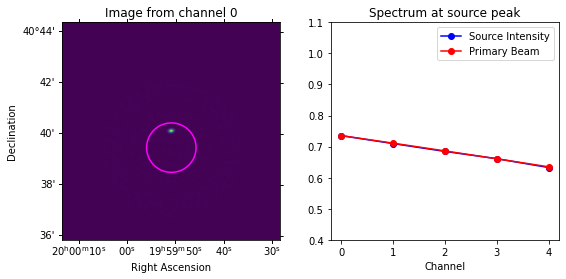

In [41]:
peak_cross,rms_cross = display_image(imprefix='try_NGVLA_cross_single')

### All baselines together
Image all baselines. 

Peak Intensity (chan0) : 0.6025428
PB at location of Intensity peak (chan0) : 0.6019481
Residual RMS : 0.0004412


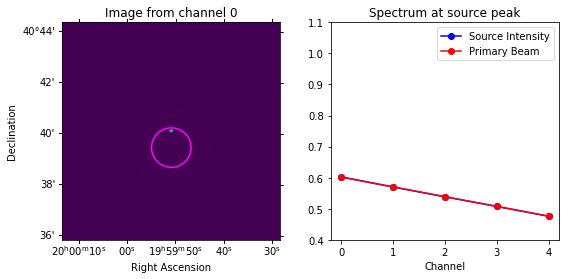

In [42]:
peak_all, rms_all = display_image(imprefix='try_NGVLA_all_single')

### Verify the measured intensity, PB and noise levels.

In [43]:
%run -i Sim_Heterogeneous_Array_Script.py

In [44]:
antsels = getBaselineTypes(tel='NGVLA')
meas_peaks = {'A':peak_18m, 'B':peak_6m, 'cross':peak_cross, 'all':peak_all}
meas_rms = {'A':rms_18m, 'B':rms_6m, 'cross':rms_cross, 'all':rms_all}
checkVals(vis='sim_data_NGVLA.ms',field='0',spw='0:0',antsels=antsels, \
          meas_peaks=meas_peaks, meas_rms=meas_rms,tel='NGVLA')

print("\n")
   

,Baseline Types,Vis Mean (V=I=P),Vis Std (sim),Vis Std (norm sim),Vis Std (calc),Number of Data Pts,Weight (calc),Weight (sim),Int Jy/bm (calc),Int Jy/bm (meas),RMS mJy (calc),RMS mJy (meas)
0,18m-18m,0.5687,0.0102,1.0000,1.0000,378.0000,1.0000,1.0000,0.5687,0.5719,0.5253,0.4892
1,6m-6m,0.9371,0.0885,8.6708,9.0000,180.0000,0.0123,0.0123,0.9371,0.9383,6.5999,6.3216
2,18m-6m,0.7313,0.0310,3.0341,3.0000,630.0000,0.1111,0.1111,0.7300,0.7354,1.2344,1.1486
3,All,-NA-,-NA-,-NA-,-NA-,-NA,-NA-,-NA-,0.5958,0.6025,0.4821,0.4412


Calculated PB size for type A (dia=18.00) : 1.43240 arcmin
Calculated PB size for type B (dia=6.00) : 4.29720 arcmin




In the above table,
 - Vis Mean : Mean of the visibility values. Representative of the source intensity (1 point source at phase center)
 - Vis StdDev : StdDev of the visibility values. Measurement of noise level.
 - Number of Pts : Number of data points (nbaselines x nchan x npol x ntimesteps).  In the above table, nchan=1
 - Mean Weight : Mean of the weight_spectrum column in the MS. 
 - Calc Int : Expected intensity. Same as the Vis Mean, for separate baseline types. Calculated as weighted average for the all-baseline case. 
 - Meas Int : Peak source intensity measured from the imaging results
 - Calc RMS : Expected image RMS. Calculated as described above.
 - Mean RMS : Measured image RMS from the residual image, within the PB mask area. 
 
 
The above single pointing tests are sufficient to verify that the simulation code is indeed working (this is one field from a two pointing mosaic dataset) as is the ability to image data from a heterogenous array. The match between intensity and primary beam for this 1 Jy source indicates accurate flux recovery, and weights, noise and image rms levels are consistent with theoretical expectations. 

The tests below cover joint mosaic imaging. 

## Run the Imaging tests for a Mosaic

In [45]:
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0,1',antsel='A', tel='NGVLA')
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0,1',antsel='B', tel='NGVLA')
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0,1',antsel='cross', tel='NGVLA')
imageAnts(vis='sim_data_NGVLA.ms',imname='try_NGVLA', field='0,1',antsel='all', tel='NGVLA')


### 18m-18m
Image only the 18m-18m baselines for a joint mosaic. For this 1 Jy source, the image and the PB values match. 

Peak Intensity (chan0) : 0.7006677
PB at location of Intensity peak (chan0) : 0.7001971
Residual RMS : 0.0004792


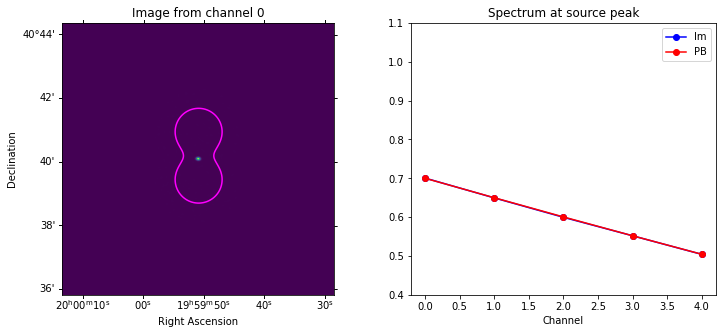

In [46]:
mospeak_18m,mosrms_18m = display_image(imprefix='try_NGVLA_A_mosaic')

### 6m-6m
Image only the 6m-6m baselines for a joint mosaic. The joint PB is larger than the 18m PB. For this 1 Jy source, the Sky and PB match. 

Peak Intensity (chan0) : 0.9887270
PB at location of Intensity peak (chan0) : 0.9992638
Residual RMS : 0.0050288


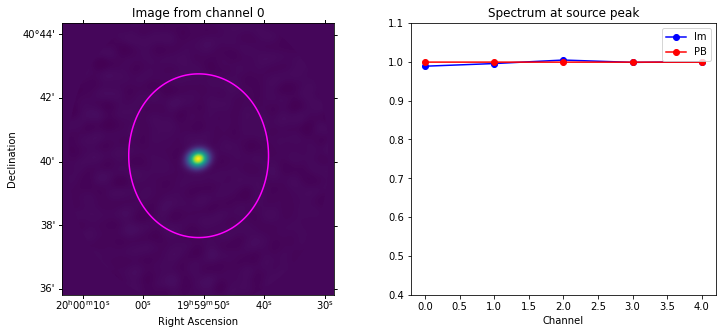

In [47]:
mospeak_6m,mosrms_6m = display_image(imprefix='try_NGVLA_B_mosaic')

### 18m-6m 

Image the cross baselines and check that the values of Sky, PB and RMS match the predictions. 

Peak Intensity (chan0) : 0.9445462
PB at location of Intensity peak (chan0) : 0.9456989
Residual RMS : 0.0011222


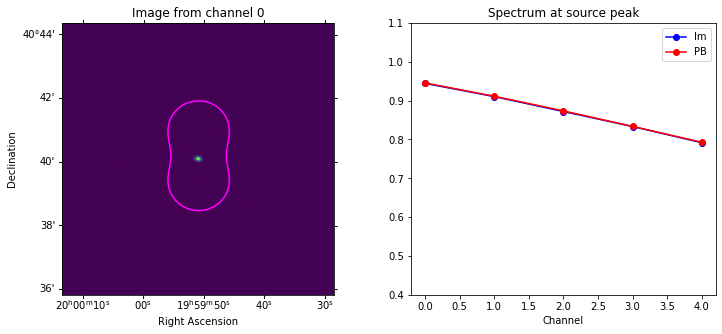

In [48]:
mospeak_cross,mosrms_cross = display_image(imprefix='try_NGVLA_cross_mosaic')

### All baselines together

Image all baselines together with a mosaic. 

Peak Intensity (chan0) : 0.7478377
PB at location of Intensity peak (chan0) : 0.7477075
Residual RMS : 0.0004342


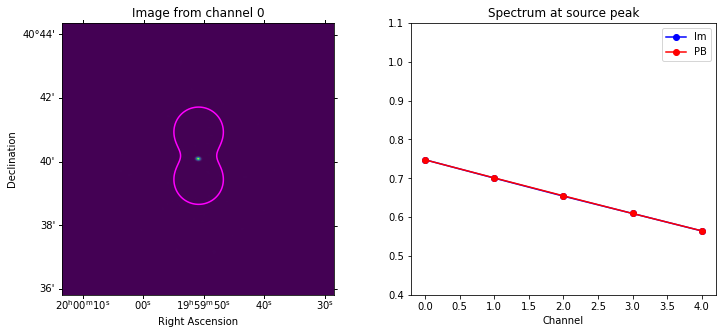

In [49]:
mospeak_all,mosrms_all = display_image(imprefix='try_NGVLA_all_mosaic')

Some qualitative observations : 
- The intensity and PB values match for all cases.
- The shapes of the joint mosaic PBs for all 4 imaging cases are consistent with expectations from relative beam size and the number of data points per type. 

Note : The theoretical calculation from the single pointing case was not performed for the joint mosaic case. To do so, we would have to image/calculate the numbers for the second pointing separately, and then perform the appropriate PB-weighted means and quadrature sums. 


# Setting up and using a vp table

In [50]:
%run -i Sim_Heterogeneous_Array_Script.py
%run -i Display_Experiments_Script.py

In [51]:
## Make float images
makeVPImage(imname='sim_vp_KSA_float_A.im',tel='KSA',atype='A',dtype='float')
makeVPImage(imname='sim_vp_KSA_float_B.im',tel='KSA',atype='B',dtype='float')

In [52]:
## Make complex images
makeVPImage(imname='sim_vp_KSA_complex_A.im',tel='KSA',atype='A',dtype='complex')
makeVPImage(imname='sim_vp_KSA_complex_B.im',tel='KSA',atype='B',dtype='complex')

In [53]:
## Make float image vp table
makeVPTable(vptab='pbmod_KSA_float.vptable',pbA='sim_vp_KSA_float_A.im',pbB='sim_vp_KSA_float_B.im',dtype='float')
## Make complex image vp table
makeVPTable(vptab='pbmod_KSA_complex.vptable',pbA='sim_vp_KSA_complex_A.im',pbB='sim_vp_KSA_complex_B.im',dtype='complex')

In [54]:
## Make a new MS for the 'Kitchen Sink Array'
## Pick the same settings as NGVLA, but only change the dish sizes. 
makeMSFrame(msn='vp_sim_data', tel='NGVLA')

Making an MS named : vp_sim_data_NGVLA.ms


Completed ddi 0  process time 0.81 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.76 s...                                     
                                                  
overwrite_encoded_chunks True


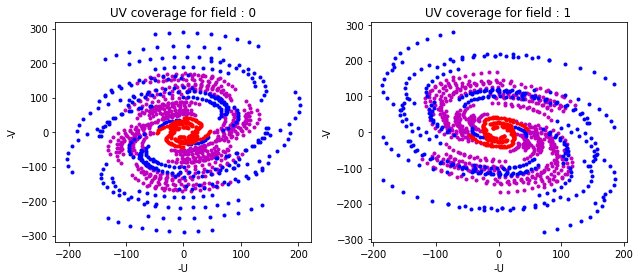

In [21]:
XPlot(vis='vp_sim_data_NGVLA.ms', ptype='uvcov',forceconvert=True,tel_name='ngVLA')


In [55]:
listobs_jupyter(vis='vp_sim_data_NGVLA.ms')

           MeasurementSet Name:  /home/vega/rurvashi/TestCASA/NoteBooks/Simulation-in-CASA/Heterogeneous_Array_Simulation_and_Imaging/vp_sim_data_NGVLA.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: NGVLA1(12 antennas)
Data records: 1188       Total elapsed time = 36000 seconds
   Observed from   03-Oct-2020/21:18:48.0   to   04-Oct-2020/07:18:48.0 (UTC)

Fields: 2
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake1               19:59:28.500000 +40.43.41.50000 J2000   0            594
  1         fake2               19:59:28.500000 +40.45.11.50000 J2000   1            594
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      Band5      5   TOPO   40000.000   2000000.000  10000000.0  44000.0000   XX  YY
Antennas: 12 'name'='station' 
   ID=   0-4: 'm140'='P', 'm14

Note that the dish diameter in the ANTENNA subtable is still 18m and 6m. However, the following step will test the use of a vptable with beams that match 20m and 10m dish diameters. This tests the over-riding ability of the vptable (instead of simply defaulting to Airy disks defined from the ANTENNA subtable). 

In [56]:
## This example uses float-valued primary beam models. 
predictImager(msname='vp_sim_data_NGVLA.ms',imname_true='sim_onepoint_true_ngvla.im', tel='NGVLA',vptable='pbmod_KSA_float.vptable')
copyModelToData(msname='vp_sim_data_NGVLA.ms')


Completed ddi 0  process time 0.47 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.55 s...                                     
                                                  
overwrite_encoded_chunks True


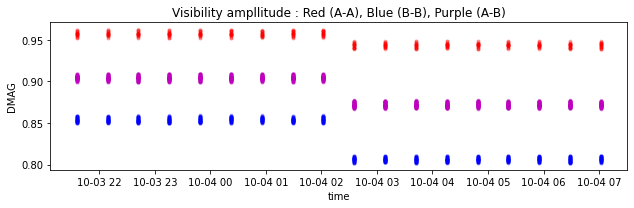

In [22]:
XPlot(vis='vp_sim_data_NGVLA.ms', ptype='amp-time',forceconvert=True,tel_name='ngVLA')


In [57]:
imageAnts(vis='vp_sim_data_NGVLA.ms',imname='vp_try_NGVLA', field='0',antsel='A',tel='NGVLA',vptable='pbmod_KSA_float.vptable')
imageAnts(vis='vp_sim_data_NGVLA.ms',imname='vp_try_NGVLA', field='0',antsel='B',tel='NGVLA',vptable='pbmod_KSA_float.vptable')
imageAnts(vis='vp_sim_data_NGVLA.ms',imname='vp_try_NGVLA', field='0',antsel='cross',tel='NGVLA',vptable='pbmod_KSA_float.vptable')
imageAnts(vis='vp_sim_data_NGVLA.ms',imname='vp_try_NGVLA', field='0',antsel='all',tel='NGVLA',vptable='pbmod_KSA_float.vptable')


Peak Intensity (chan0) : 0.8618081
PB at location of Intensity peak (chan0) : 0.8621622
Residual RMS : 0.0001920


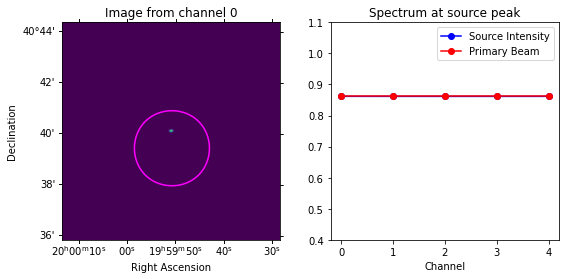

In [58]:
peak_A, rms_A = display_image(imprefix='vp_try_NGVLA_A_single')

Peak Intensity (chan0) : 0.9624646
PB at location of Intensity peak (chan0) : 0.9627022
Residual RMS : 0.0004240


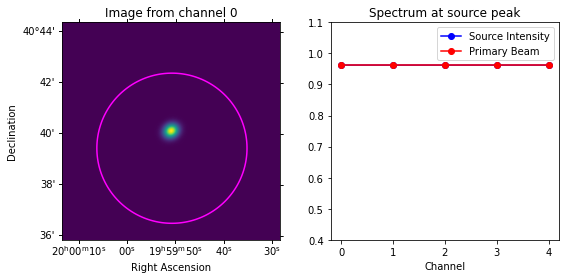

In [59]:
peak_B, rms_B = display_image(imprefix='vp_try_NGVLA_B_single')

Peak Intensity (chan0) : 0.9093949
PB at location of Intensity peak (chan0) : 0.9095665
Residual RMS : 0.0002012


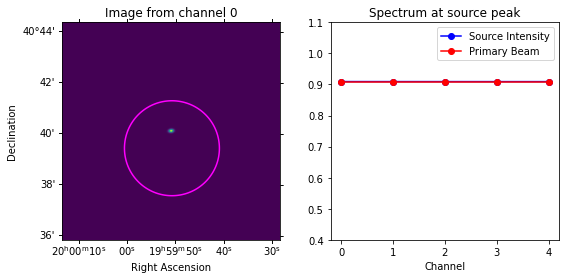

In [60]:
peak_cross, rms_cross = display_image(imprefix='vp_try_NGVLA_cross_single')

Peak Intensity (chan0) : 0.8700604
PB at location of Intensity peak (chan0) : 0.8702645
Residual RMS : 0.0001585


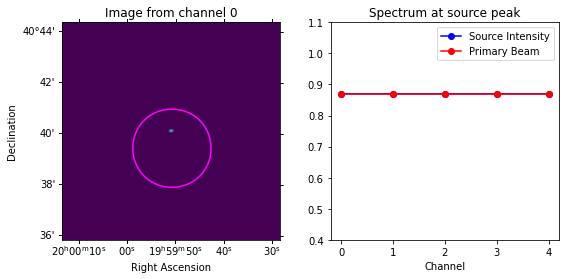

In [61]:
peak_all, rms_all = display_image(imprefix='vp_try_NGVLA_all_single')

The following call is just a test to check that the 'complex' vptable format also works. For now, we just predict visibilities and make a plot to compare with the one above that used a 'float' vptable.

In [62]:
## This example uses complex-valued primary beam models. 
predictImager(msname='vp_sim_data_NGVLA.ms',imname_true='sim_onepoint_true_ngvla.im', tel='NGVLA',vptable='pbmod_KSA_complex.vptable')
copyModelToData(msname='vp_sim_data_NGVLA.ms')

Completed ddi 0  process time 0.60 sTRUM....PECTRAL_WINDOW_ID...                    
Completed subtables  process time 0.59 s...                                     
                                                  
overwrite_encoded_chunks True


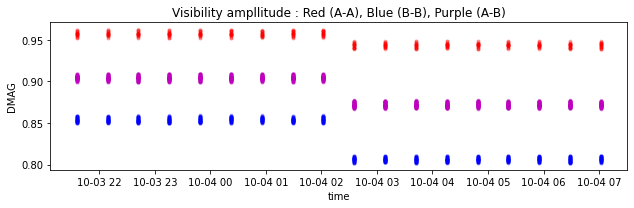

In [23]:
# Run to compare with the above plot made from 'float' primary beams. They are equivalent. 
XPlot(vis='vp_sim_data_NGVLA.ms', ptype='amp-time',forceconvert=True,tel_name='ngVLA')
